In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp, wilcoxon, ttest_ind, ranksums, sem
%matplotlib inline

In [2]:
LABEL_SIZE = 14; TITLE_SIZE = 16; LEGEND_SIZE = 12

def finalize(ax): 
    ax.tick_params(direction='out')
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.label.set_size(LABEL_SIZE)
    ax.xaxis.label.set_size(LABEL_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

## Difference in recall between reading passage one or three times

In [3]:
read_once = pd.read_csv('data/pilot_1x40_oct_14_control/info_cleaned.csv')
read_thrice = pd.read_csv('data/pilot_3x40_oct_14_control/info_cleaned.csv')

In [4]:
read_once['number_of_words'] = read_once.response.str.split(' ').apply(len)
read_thrice['number_of_words'] = read_thrice.response.str.split(' ').apply(len)

In [5]:
read_once['number_of_uniq_words'] = read_once.response.str.split(' ').apply(set).apply(len)
read_thrice['number_of_uniq_words'] = read_thrice.response.str.split(' ').apply(set).apply(len)

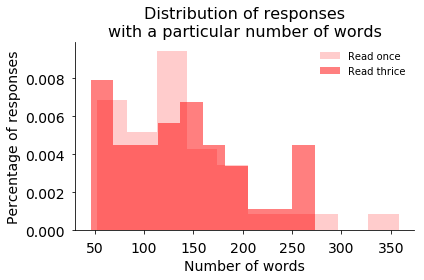

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

read_once['number_of_words'].hist(label='Read once', color='r', alpha=0.2, grid=False, density=True, ax=ax)
read_thrice['number_of_words'].hist(label='Read thrice', color='r', alpha=0.5, grid=False, density=True, ax=ax)

plt.ylabel('Percentage of responses', size=LABEL_SIZE)
plt.xlabel('Number of words', size=LABEL_SIZE)
plt.title('Distribution of responses\nwith a particular number of words', size=TITLE_SIZE)

plt.legend(frameon=False)
finalize(ax)
plt.tight_layout()
plt.savefig('diffs_reading_times.pdf', dpi=1000)

In [7]:
read_once['number_of_words'].describe()

count     38.000000
mean     136.131579
std       64.140122
min       52.000000
25%       90.500000
50%      127.000000
75%      158.750000
max      358.000000
Name: number_of_words, dtype: float64

In [8]:
read_thrice['number_of_words'].describe()

count     39.000000
mean     139.461538
std       64.895806
min       46.000000
25%       86.500000
50%      134.000000
75%      177.000000
max      273.000000
Name: number_of_words, dtype: float64

In [9]:
ks_2samp(read_once['number_of_words'], read_thrice['number_of_words'])

Ks_2sampResult(statistic=0.14574898785425106, pvalue=0.7754755216281364)

In [10]:
ttest_ind(read_once['number_of_words'], read_thrice['number_of_words'])

Ttest_indResult(statistic=-0.22641004237217544, pvalue=0.8214984464874829)

In [11]:
ranksums(read_once['number_of_words'], read_thrice['number_of_words'])

RanksumsResult(statistic=-0.2852838922909325, pvalue=0.775426652421743)

## Chain versus network analyzed by number of words

In [12]:
chain = pd.read_csv('data/pilot1x10_sept_27/info_cleaned.csv')
network = pd.read_csv('data/pilot3x5x5_sept_30/info_cleaned.csv')

In [13]:
chain['number_of_words'] = chain.response.str.split(' ').apply(len).astype(float)
network['number_of_words'] = network.response.str.split(' ').apply(len).astype(float)

In [14]:
for gen in range(0, 5):
    print(gen, network[network.generation == gen].number_of_words.mean())

0 105.93333333333334
1 78.93333333333334
2 63.266666666666666
3 45.93333333333333
4 46.57142857142857


In [15]:
for gen in range(0, 5):
    print(gen, chain[chain.generation == gen].number_of_words.mean())

0 118.6
1 69.5
2 57.0
3 38.9
4 33.142857142857146


In [16]:
chain['number_of_uniq_words'] = chain.response.str.split(' ').apply(set).apply(len)
network['number_of_uniq_words'] = network.response.str.split(' ').apply(set).apply(len)

In [17]:
grouped_chain = chain.sort_values('generation').groupby(['replication'])
chain_response_lengths = list(grouped_chain['number_of_words'].apply(list))

In [18]:
grouped_network = network.groupby(['replication', 'generation'])
network_response_lengths = []; replication_counter = 0; replication_lengths = []
for i, row in grouped_network:
    if i[0] > replication_counter:
        network_response_lengths.append(replication_lengths)
        replication_lengths = []; replication_counter += 1
    
    replication_lengths.append(list(row['number_of_words']))
network_response_lengths.append(replication_lengths)

In [19]:
flattened_network_response_length = [None]*5
for i in range(0, 5):
    for single_network in network_response_lengths:
        if flattened_network_response_length[i] is None:
            flattened_network_response_length[i] = []
        flattened_network_response_length[i].extend(single_network[i])

In [20]:
network_df = pd.DataFrame(flattened_network_response_length)
chain_df = pd.DataFrame(chain_response_lengths)

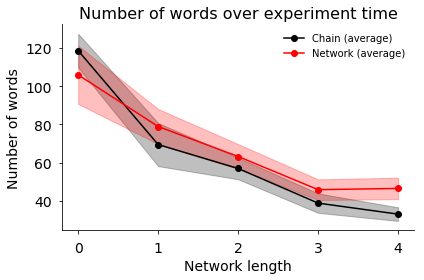

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

## Plot the chain results
# for single_chain in chain_response_lengths:
#     plt.scatter(range(0, len(single_chain)), single_chain, color='black', alpha=0.15)

mean_length = np.array(chain_df.apply(np.nanmean, axis=0))
sem_length = np.array(chain_df.apply(np.nanstd, axis=0))/np.sqrt(chain_df.shape[0]*chain_df.shape[1])

plt.plot(range(0, 5), mean_length, color='black', alpha=1.0, marker='o', label='Chain (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='black', alpha=0.25)

## Plot the network results
# for single_network in network_response_lengths:
#     for i in range(0, len(single_network)):
#         plt.scatter([i]*len(single_network[i]), single_network[i], color='red', alpha=0.15)

mean_length = network_df.apply(np.nanmean, axis=1)
sem_length = network_df.apply(np.nanstd, axis=1)/np.sqrt(network_df.shape[0]*network_df.shape[1])

plt.plot(range(0, 5), mean_length, color='red', alpha=1.0, marker='o', label='Network (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='red', alpha=0.25)

## Finish up with styling
plt.ylabel('Number of words', size=LABEL_SIZE)
plt.xlabel('Network length', size=LABEL_SIZE)
plt.title('Number of words over experiment time', size=TITLE_SIZE)
# plt.ylim(0, 125)
plt.legend(frameon=False)

finalize(ax)
plt.tight_layout()
plt.savefig('network_vs_chain.pdf', dpi=1000)

## Automatic SVO Parsing

In [22]:
from svo_parsing.subject_extraction import clean_document, extract_subject, tag_sentences, get_svo

In [23]:
all_chain_responses = list(grouped_chain['response'].apply(list))

In [24]:
# Try and compute the following in parallel
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool as Pool

def kill_pool(err):
    print(err)
    pool.terminate()

In [25]:
def get_propositions(response):
    cleaned_response = clean_document(response)
    subjects = extract_subject(cleaned_response)
        
    propositions = []
    for subject in subjects:
        tagged_sents = tag_sentences(subject, cleaned_response)
        for sentence in tagged_sents:
            svo = get_svo(sentence, subject)
            if svo != {}:
                propositions.append('-'.join([svo['subject'], svo['action'], svo['object']]))
    
    return propositions

In [26]:
pool = Pool(processes = cpu_count()-2)

chain_propositions = [[]]*len(all_chain_responses); results = []; ids = []
for rep, single_chain_responses in enumerate(all_chain_responses): 
    for i, response in enumerate(single_chain_responses):
        result = pool.apply_async(get_propositions, [response], error_callback=kill_pool)
        results.append(result)
        ids.append((rep, i))

for i, result in enumerate(results):
    (rep, i) = ids[i]
    propositions = result.get(timeout=None) 
    chain_propositions[rep].append(len(propositions))

pool.close()
pool.terminate()

In [27]:
all_network_responses = []; replication_counter = 0; single_network_responses = []
for i, row in grouped_network:
    if i[0] > replication_counter:
        all_network_responses.append(single_network_responses)
        single_network_responses = []; replication_counter += 1
    
    single_network_responses.append(list(row['response']))
all_network_responses.append(single_network_responses)

In [30]:
pool = Pool(processes = cpu_count()-2)

network_propositions = [[[]]]*len(all_network_responses); results = []; ids = []
for rep, single_network_responses in enumerate(all_network_responses): 
    for j, level in enumerate(single_network_responses):
        for i, response in enumerate(level):
            result = pool.apply_async(get_propositions, [response], error_callback=kill_pool)
            results.append(result)
            ids.append((rep, j, i))

for i, result in enumerate(results):
    (rep, j, i) = ids[i]
    print((rep, j, i))
    propositions = result.get(timeout=None)
    if len(network_propositions[rep]) == j:
        network_propositions[rep].append([])
    network_propositions[rep][j].append(propositions)

pool.close()
pool.terminate()

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(0, 3, 0)
(0, 3, 1)
(0, 3, 2)
(0, 4, 0)
(0, 4, 1)
(0, 4, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(1, 3, 0)
(1, 3, 1)
(1, 3, 2)
(1, 4, 0)
(1, 4, 1)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
(2, 3, 0)
(2, 3, 1)
(2, 3, 2)
(2, 4, 0)
(2, 4, 1)
(2, 4, 2)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 2, 0)
(3, 2, 1)
(3, 2, 2)
(3, 3, 0)
(3, 3, 1)
(3, 3, 2)
(3, 4, 0)
(3, 4, 1)
(3, 4, 2)
(4, 0, 0)
(4, 0, 1)
(4, 0, 2)
(4, 1, 0)
(4, 1, 1)
(4, 1, 2)
(4, 2, 0)
(4, 2, 1)
(4, 2, 2)
(4, 3, 0)
(4, 3, 1)
(4, 3, 2)
(4, 4, 0)
(4, 4, 1)
(4, 4, 2)


In [46]:
len(network_propositions[0]), len(network_propositions[0][0]), len(network_propositions[0][0][0])

(5, 15, 45)

In [43]:
flattened_network_propositions = [None]*5
for i in range(0, 5):
    for single_network in network_propositions:
        if flattened_network_propositions[i] is None:
            flattened_network_propositions[i] = []
        flattened_network_propositions[i].extend(single_network[i])

In [45]:
len(flattened_network_propositions)

5

In [32]:
network_df = pd.DataFrame(flattened_network_propositions)
chain_df = pd.DataFrame(chain_propositions)

ValueError: x and y must have same first dimension, but have shapes (5,) and (47,)

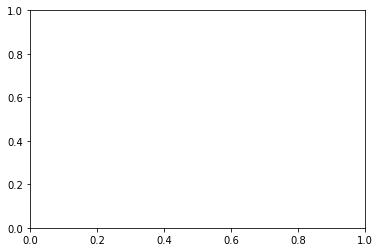

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

mean_length = np.array(chain_df.apply(np.nanmean, axis=0))
sem_length = np.array(chain_df.apply(np.nanstd, axis=0))/np.sqrt(chain_df.shape[0]*chain_df.shape[1])

plt.plot(range(0, 5), mean_length, color='black', alpha=1.0, marker='o', label='Chain (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='black', alpha=0.25)

mean_length = network_df.apply(np.nanmean, axis=1)
sem_length = network_df.apply(np.nanstd, axis=1)/np.sqrt(network_df.shape[0]*network_df.shape[1])

plt.plot(range(0, 5), mean_length, color='red', alpha=1.0, marker='o', label='Network (average)')
plt.fill_between(range(0, 5), mean_length-2*sem_length, mean_length+2*sem_length, color='red', alpha=0.25)

## Finish up with styling
plt.ylabel('Number of propositions', size=LABEL_SIZE)
plt.xlabel('Network length', size=LABEL_SIZE)
plt.title('Number of propositions over experiment time', size=TITLE_SIZE)
plt.ylim(0, 25)
plt.legend(frameon=False)

finalize(ax)
plt.tight_layout()
plt.savefig('network_vs_chain_svo.pdf', dpi=1000)